# Домашнее задание 2: Создание и оптимизация ResNet18

## Общая цель

Поэтапная разработка кастомной ResNet18 модели для классификации Tiny ImageNet с анализом влияния различных архитектурных решений на производительность.  

Датасет: Tiny ImageNet (200 классов) - выберите 10 классов самостоятельно для работы  


## Часть 1: Подготовка данных
класс `TinyImageNetDataset`, наследующий от `torch.utils.data.Dataset`:    
* Метод `__init__`: инициализация путей к данным, загрузка списка изображений и меток
* Метод `__len__`: возврат количества примеров в датасете
* Метод `__getitem__`: загрузка и возврат одного примера (изображение + метка)


Реализация в файле [TinyImageNetDataset.py](./TinyImageNetDataset.py)

In [1]:
import sys
from pathlib import Path

ROOT_DIR = Path.cwd().parent
sys.path.insert(0, str(ROOT_DIR))

In [2]:
from TinyImageNetDataset import TinyImageNetDataset

In [5]:
from torchvision import transforms


In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900',
            'n01698640', 'n01742172', 'n01768244', 'n01770393',
            'n01774384', 'n01774750',
            # 'n01855672', 'n01882714', 'n01910747', 'n01917289',
            # 'n01930112', 'n01943899', 'n01944390', 'n01945685',
            # 'n01950731', 'n01955084'
          ]

# classes = ["n12267677", "n09428293"]

train_dataset = TinyImageNetDataset(
    root_dir="../hw_2/tiny-imagenet-200",
    # transform=train_transform,
    transform=transform,
    selected_classes=classes
)

val_dataset = TinyImageNetDataset(
    root_dir="../hw_2/tiny-imagenet-200",
    # transform=val_transform,
    transform=transform,
    selected_classes=classes
)

Проверяем что датасет работает и смотрим какие классы будем распознавать

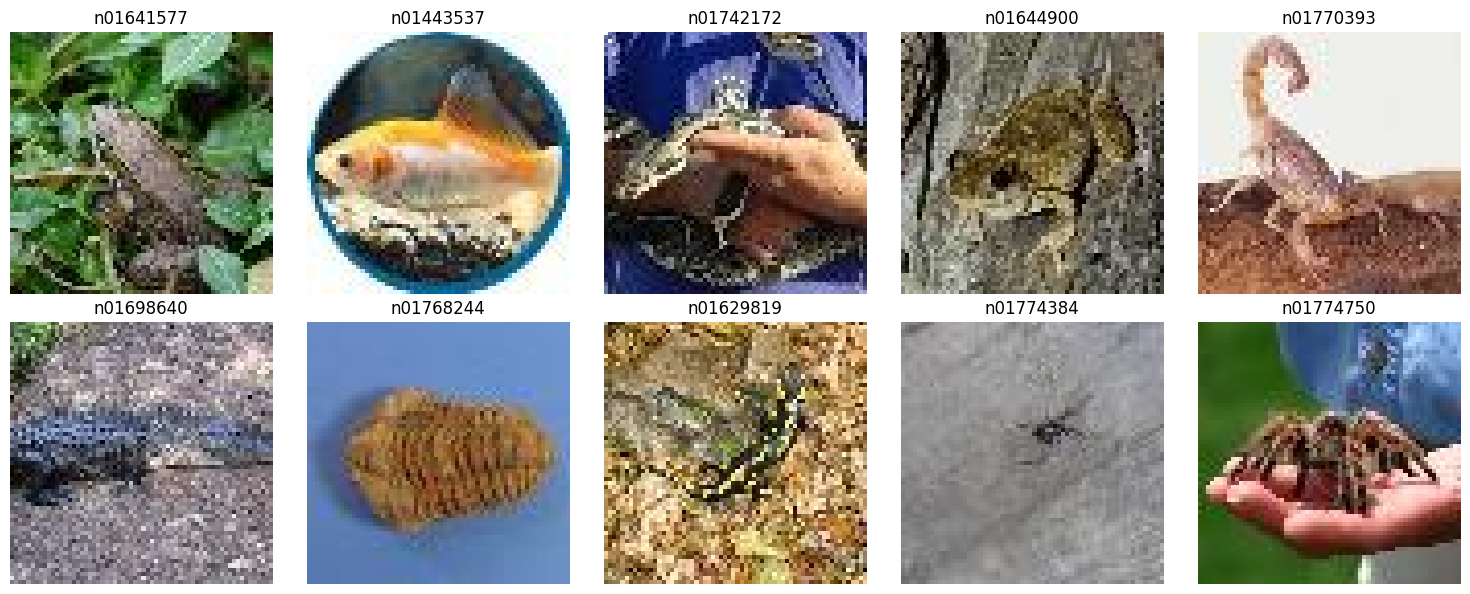

['n01641577', 'n01443537', 'n01742172', 'n01644900', 'n01770393', 'n01698640', 'n01768244', 'n01629819', 'n01774384', 'n01774750']


In [7]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

train_dataset.idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

num_classes = len(train_dataset.class_to_idx)

classes_list = []

class_samples = {}

for img, label in train_dataset:
    label_idx = label

    if label_idx not in class_samples:
        class_samples[label_idx] = img

    if len(class_samples) == num_classes:
        break

plt.figure(figsize=(15, 6))

for i, (class_idx, img) in enumerate(class_samples.items()):
    img = F.to_pil_image(img)
    classes_list.append(train_dataset.idx_to_class[class_idx])
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(train_dataset.idx_to_class[class_idx])
    plt.axis("off")

plt.tight_layout()
plt.show()

print(classes_list)

In [8]:
print(f"data size : {len(train_dataset)}")

data size : 5000


## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

```
Input
  ↓
Conv2d(kernel_size=3, padding=1, stride=stride)
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
Conv2d(kernel_size=3, padding=1, stride=1)
  ↓
BatchNorm2d
  ↓
  + ← Skip Connection (с возможностью downsample)
  ↓
ReLU
  ↓
Output
```

Реализация в файле [BasicBlock.py](./BasicBlock.py)

## 2.2. Реализация ResNet18

```
Input (3, 64, 64)
  ↓
Conv2d(3→64, kernel_size=7, stride=2, padding=3)  # или 3x3, stride=1 для Tiny ImageNet
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
MaxPool2d(kernel_size=3, stride=2, padding=1)  # опционально для Tiny ImageNet
  ↓
Layer1: 2x Basic Block (64 channels)
  ↓
Layer2: 2x Basic Block (128 channels, stride=2 в первом блоке)
  ↓
Layer3: 2x Basic Block (256 channels, stride=2 в первом блоке)
  ↓
Layer4: 2x Basic Block (512 channels, stride=2 в первом блоке)  # ОПЦИОНАЛЬНО
  ↓
AdaptiveAvgPool2d(output_size=(1, 1))
  ↓
Flatten
  ↓
Linear(512 → 10)  # 10 классов
  ↓
Output
```

Реализация в файле [ResNet18.py](./ResNet18.py)

In [9]:
from ResNet18 import ResNet18

Смотрим сколько параметров в модели

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# base_model = ResNet18(use_layer4=False)
base_model = ResNet18(
    channels=[64, 128, 256, 256]
    , num_blocks=[2,2,2,1])
print(f"Total parameters: {count_parameters(base_model):,}")


Total parameters: 4,024,394


Делим выборку на train и test

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(train_dataset)))
labels = [train_dataset[i][1] for i in indices]

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Функция train [здесь](train.py)

In [13]:
from train import train

In [14]:
base_train_losses, base_val_losses, base_train_accs, base_val_accs = train(base_model, train_loader, val_loader)

Epoch [1/25] | Train Loss: 1.9775, Train Acc: 0.2939 | Val Loss: 1.9603, Val Acc: 0.3064
Epoch [2/25] | Train Loss: 1.7426, Train Acc: 0.3896 | Val Loss: 1.7902, Val Acc: 0.3787
Epoch [3/25] | Train Loss: 1.6310, Train Acc: 0.4296 | Val Loss: 2.4463, Val Acc: 0.3430
Epoch [4/25] | Train Loss: 1.5527, Train Acc: 0.4499 | Val Loss: 1.6961, Val Acc: 0.3982
Epoch [5/25] | Train Loss: 1.4682, Train Acc: 0.4804 | Val Loss: 1.9131, Val Acc: 0.3377
Epoch [6/25] | Train Loss: 1.4169, Train Acc: 0.4975 | Val Loss: 1.7224, Val Acc: 0.4457
Epoch [7/25] | Train Loss: 1.3178, Train Acc: 0.5392 | Val Loss: 1.6158, Val Acc: 0.4594
Epoch [8/25] | Train Loss: 1.2584, Train Acc: 0.5675 | Val Loss: 1.4468, Val Acc: 0.5100
Epoch [9/25] | Train Loss: 1.2092, Train Acc: 0.5938 | Val Loss: 1.6206, Val Acc: 0.4582
Epoch [10/25] | Train Loss: 1.1571, Train Acc: 0.6022 | Val Loss: 1.8885, Val Acc: 0.4217
Epoch [11/25] | Train Loss: 1.1314, Train Acc: 0.6163 | Val Loss: 1.5044, Val Acc: 0.5113
Epoch [12/25] | Tra

In [22]:
print(max(base_train_accs), max(base_val_accs))

0.9789186507936508 0.5958984375


In [15]:
import matplotlib.pyplot as plt

def draw_graphs(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    
    # Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


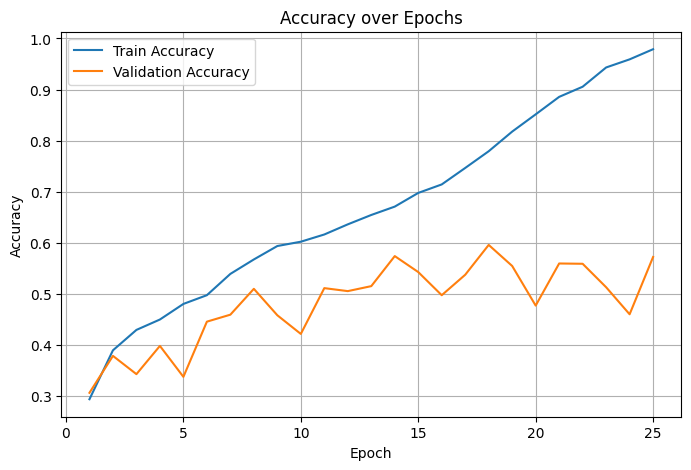

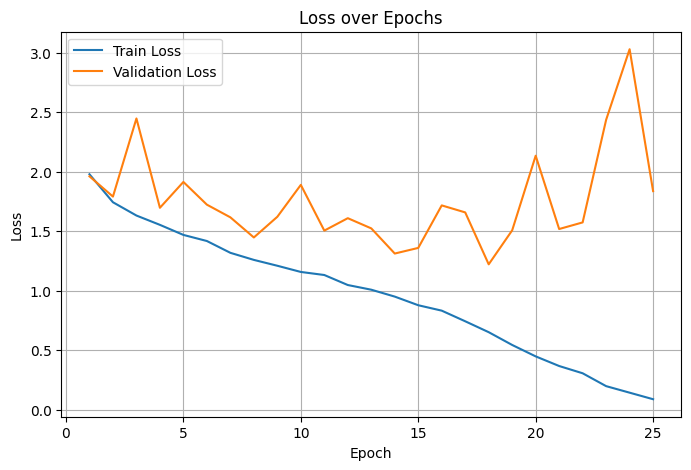

In [16]:
draw_graphs(base_train_losses, base_val_losses, base_train_accs, base_val_accs)

## Часть 3: Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

Цель: Изучение влияния количества каналов на производительность.

Эксперимент:

    Создайте 2 варианта модели:
        Вариант A: 32 → 64 → 128 → 256 каналов
        Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)
    Обучите обе модели с теми же гиперпараметрами
    Сравните:
        Количество параметров
        Validation accuracy

Результат:

    Таблица сравнения
    Графики accuracy и loss для обоих вариантов
    Вывод: какая конфигурация лучше?


In [17]:
model_3_1_A = ResNet18(channels=[32, 64, 128, 256])
model_3_1_B = ResNet18(use_layer4=False, channels=[64, 128, 256])

In [18]:
print(f"3 1 A total parameters: {count_parameters(model_3_1_A):,}")
print(f"3 1 B total parameters: {count_parameters(model_3_1_B):,}")

3 1 A total parameters: 2,809,866
3 1 B total parameters: 2,777,674


### 3.1.A

In [19]:
train_res_3_1_A = train(model_3_1_A, train_loader, val_loader)

Epoch [1/25] | Train Loss: 2.0081, Train Acc: 0.2684 | Val Loss: 1.9286, Val Acc: 0.3010
Epoch [2/25] | Train Loss: 1.7709, Train Acc: 0.3631 | Val Loss: 1.8783, Val Acc: 0.3193
Epoch [3/25] | Train Loss: 1.6331, Train Acc: 0.4229 | Val Loss: 1.6456, Val Acc: 0.4156
Epoch [4/25] | Train Loss: 1.5413, Train Acc: 0.4596 | Val Loss: 2.9534, Val Acc: 0.3133
Epoch [5/25] | Train Loss: 1.4464, Train Acc: 0.4965 | Val Loss: 1.5671, Val Acc: 0.4484
Epoch [6/25] | Train Loss: 1.3459, Train Acc: 0.5298 | Val Loss: 1.5571, Val Acc: 0.4795
Epoch [7/25] | Train Loss: 1.2710, Train Acc: 0.5516 | Val Loss: 1.4848, Val Acc: 0.5033
Epoch [8/25] | Train Loss: 1.2451, Train Acc: 0.5739 | Val Loss: 1.4041, Val Acc: 0.5252
Epoch [9/25] | Train Loss: 1.1743, Train Acc: 0.5878 | Val Loss: 1.4583, Val Acc: 0.5006
Epoch [10/25] | Train Loss: 1.0626, Train Acc: 0.6297 | Val Loss: 1.8484, Val Acc: 0.4721
Epoch [11/25] | Train Loss: 1.0219, Train Acc: 0.6466 | Val Loss: 1.5680, Val Acc: 0.5082
Epoch [12/25] | Tra

In [24]:
print(max(train_res_3_1_A[-2]), max(train_res_3_1_A[-1]))

0.9875992063492064 0.5763671875


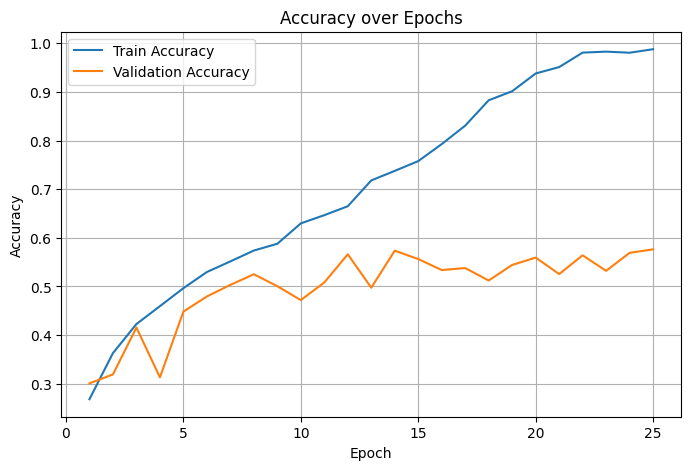

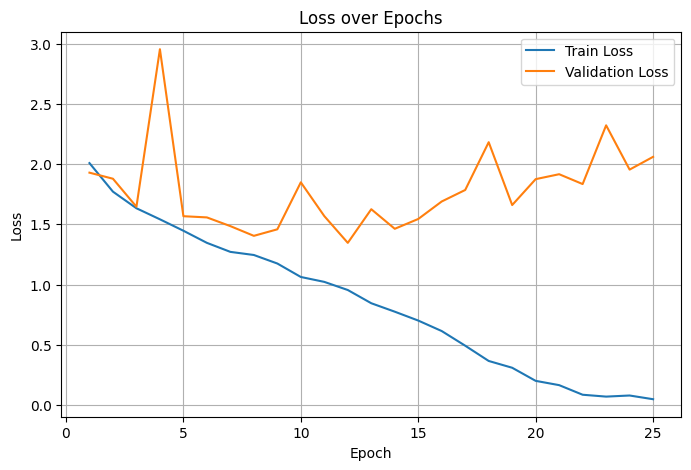

In [20]:
draw_graphs(*train_res_3_1_A)

### 3.1.B

In [25]:
train_res_3_1_B = train(model_3_1_B, train_loader, val_loader)

Epoch [1/25] | Train Loss: 1.3922, Train Acc: 0.5193 | Val Loss: 1.5599, Val Acc: 0.4758
Epoch [2/25] | Train Loss: 1.2810, Train Acc: 0.5652 | Val Loss: 1.6485, Val Acc: 0.4756
Epoch [3/25] | Train Loss: 1.2222, Train Acc: 0.5742 | Val Loss: 1.6284, Val Acc: 0.5014
Epoch [4/25] | Train Loss: 1.1673, Train Acc: 0.6044 | Val Loss: 1.9661, Val Acc: 0.3764
Epoch [5/25] | Train Loss: 1.0984, Train Acc: 0.6186 | Val Loss: 1.4104, Val Acc: 0.5500
Epoch [6/25] | Train Loss: 1.0686, Train Acc: 0.6369 | Val Loss: 1.3716, Val Acc: 0.5525
Epoch [7/25] | Train Loss: 1.0450, Train Acc: 0.6436 | Val Loss: 1.7028, Val Acc: 0.5152
Epoch [8/25] | Train Loss: 0.9868, Train Acc: 0.6734 | Val Loss: 1.2693, Val Acc: 0.5900
Epoch [9/25] | Train Loss: 0.9255, Train Acc: 0.6875 | Val Loss: 1.5009, Val Acc: 0.5264
Epoch [10/25] | Train Loss: 0.8971, Train Acc: 0.6967 | Val Loss: 1.9917, Val Acc: 0.4846
Epoch [11/25] | Train Loss: 0.8635, Train Acc: 0.7011 | Val Loss: 1.4966, Val Acc: 0.5262
Epoch [12/25] | Tra

In [28]:
print(max(train_res_3_1_B[-2]), max(train_res_3_1_B[-1]))

0.9553571428571429 0.6162109375


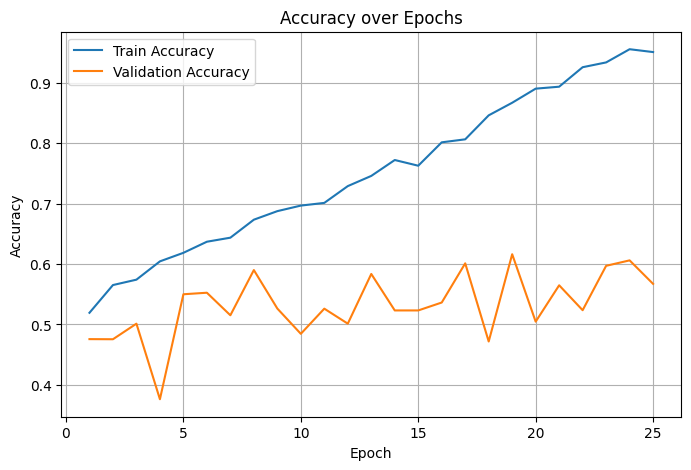

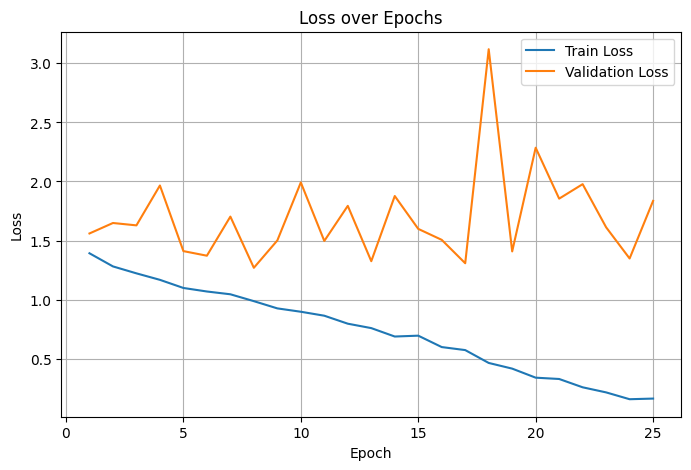

In [26]:
draw_graphs(*train_res_3_1_B)

### 3.2: Эксперименты с количеством residual блоков

Цель: Изучение влияния глубины сети (количества residual блоков) на производительность.

Эксперимент:

    Используйте лучшую конфигурацию каналов из Этапа 3.1
    Создайте 3 варианта модели с разным количеством блоков в каждом слое:
        Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)
        Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)
        Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)
    Обучите все три модели с одинаковыми гиперпараметрами


In [29]:
print(max(base_train_accs), max(base_val_accs))
print(max(train_res_3_1_A[-2]), max(train_res_3_1_A[-1]))
print(max(train_res_3_1_B[-2]), max(train_res_3_1_B[-1]))

0.9789186507936508 0.5958984375
0.9875992063492064 0.5763671875
0.9553571428571429 0.6162109375


In [30]:
best_channels = [64, 128, 256]

model_3_2_A = ResNet18(use_layer4=False, channels=best_channels, num_blocks=[1,1,1,1])
model_3_2_B = ResNet18(use_layer4=False, channels=best_channels, num_blocks=[2,2,2,2])
model_3_2_C = ResNet18(use_layer4=False, channels=best_channels, num_blocks=[3,3,3,3])

### 3.2.A

In [31]:
train_res_3_2_A = train(model_3_2_A, train_loader, val_loader)

Epoch [1/25] | Train Loss: 1.9970, Train Acc: 0.2842 | Val Loss: 1.9381, Val Acc: 0.3236
Epoch [2/25] | Train Loss: 1.7979, Train Acc: 0.3740 | Val Loss: 3.6800, Val Acc: 0.2361
Epoch [3/25] | Train Loss: 1.6718, Train Acc: 0.4112 | Val Loss: 2.1823, Val Acc: 0.3256
Epoch [4/25] | Train Loss: 1.6215, Train Acc: 0.4377 | Val Loss: 2.0183, Val Acc: 0.3725
Epoch [5/25] | Train Loss: 1.5423, Train Acc: 0.4690 | Val Loss: 2.0101, Val Acc: 0.3912
Epoch [6/25] | Train Loss: 1.4947, Train Acc: 0.4812 | Val Loss: 2.0563, Val Acc: 0.3979
Epoch [7/25] | Train Loss: 1.4673, Train Acc: 0.4958 | Val Loss: 2.5646, Val Acc: 0.3180
Epoch [8/25] | Train Loss: 1.3951, Train Acc: 0.5208 | Val Loss: 1.8233, Val Acc: 0.3832
Epoch [9/25] | Train Loss: 1.3491, Train Acc: 0.5312 | Val Loss: 1.9217, Val Acc: 0.4018
Epoch [10/25] | Train Loss: 1.2886, Train Acc: 0.5605 | Val Loss: 2.2956, Val Acc: 0.3725
Epoch [11/25] | Train Loss: 1.2544, Train Acc: 0.5754 | Val Loss: 1.7868, Val Acc: 0.4529
Epoch [12/25] | Tra

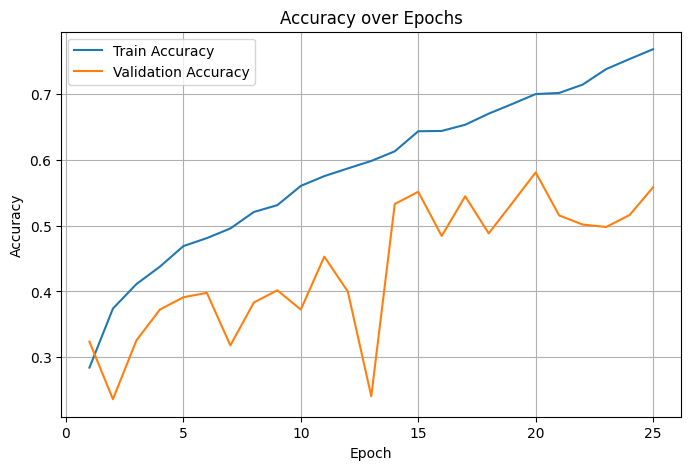

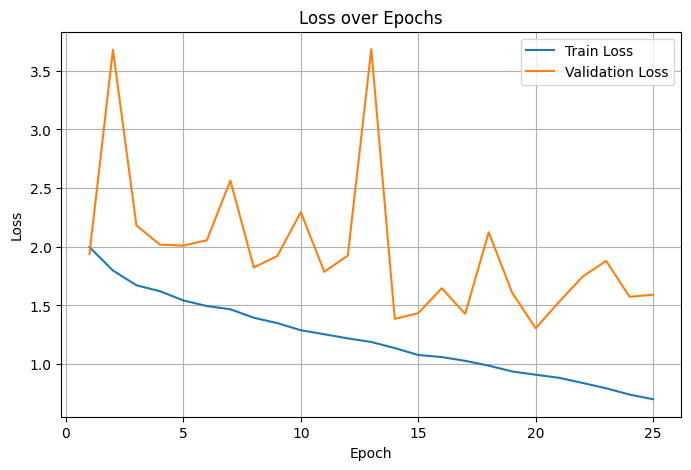

In [32]:
draw_graphs(*train_res_3_2_A)

### 3.2.B

In [33]:
train_res_3_2_B = train(model_3_2_B, train_loader, val_loader)

Epoch [1/25] | Train Loss: 2.0388, Train Acc: 0.2674 | Val Loss: 1.9685, Val Acc: 0.2797
Epoch [2/25] | Train Loss: 1.8246, Train Acc: 0.3614 | Val Loss: 2.4547, Val Acc: 0.2826
Epoch [3/25] | Train Loss: 1.7309, Train Acc: 0.3973 | Val Loss: 1.6701, Val Acc: 0.4605
Epoch [4/25] | Train Loss: 1.6313, Train Acc: 0.4315 | Val Loss: 1.8608, Val Acc: 0.3836
Epoch [5/25] | Train Loss: 1.5240, Train Acc: 0.4643 | Val Loss: 5.4507, Val Acc: 0.2520
Epoch [6/25] | Train Loss: 1.4861, Train Acc: 0.4821 | Val Loss: 1.7451, Val Acc: 0.3891
Epoch [7/25] | Train Loss: 1.4322, Train Acc: 0.5109 | Val Loss: 1.8064, Val Acc: 0.3725
Epoch [8/25] | Train Loss: 1.3939, Train Acc: 0.5112 | Val Loss: 1.6399, Val Acc: 0.4500
Epoch [9/25] | Train Loss: 1.3443, Train Acc: 0.5392 | Val Loss: 1.4534, Val Acc: 0.5225
Epoch [10/25] | Train Loss: 1.2820, Train Acc: 0.5588 | Val Loss: 1.4967, Val Acc: 0.4922
Epoch [11/25] | Train Loss: 1.2436, Train Acc: 0.5873 | Val Loss: 1.4577, Val Acc: 0.4982
Epoch [12/25] | Tra

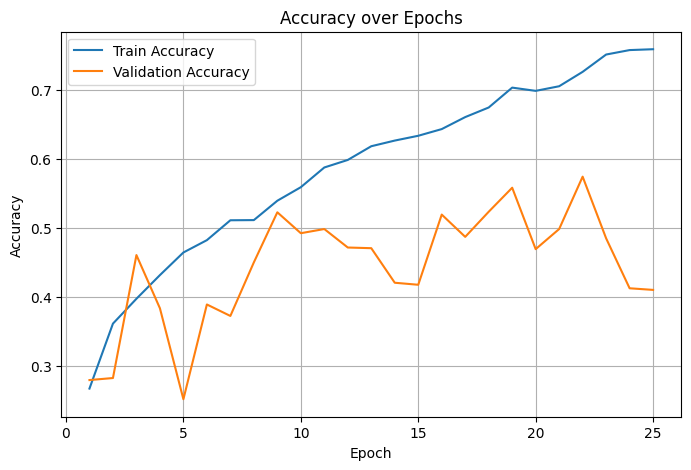

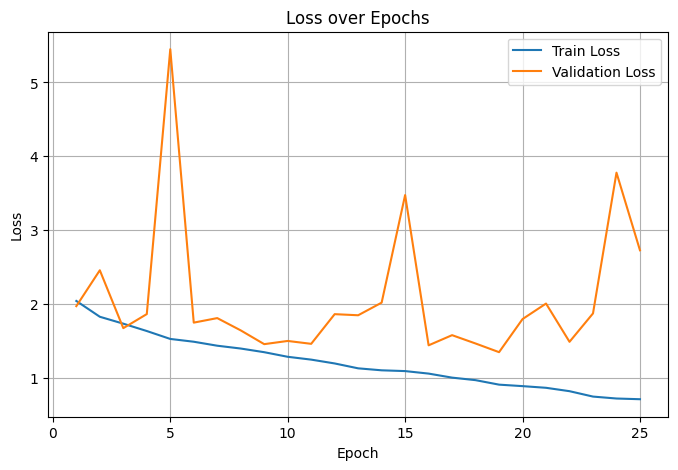

In [34]:
draw_graphs(*train_res_3_2_B)

### 3.2.C

In [35]:
train_res_3_2_C = train(model_3_2_C, train_loader, val_loader)

Epoch [1/25] | Train Loss: 2.0843, Train Acc: 0.2485 | Val Loss: 2.0480, Val Acc: 0.2730
Epoch [2/25] | Train Loss: 1.8729, Train Acc: 0.3140 | Val Loss: 1.8793, Val Acc: 0.3037
Epoch [3/25] | Train Loss: 1.7876, Train Acc: 0.3767 | Val Loss: 1.8020, Val Acc: 0.3760
Epoch [4/25] | Train Loss: 1.6850, Train Acc: 0.4070 | Val Loss: 2.0363, Val Acc: 0.3221
Epoch [5/25] | Train Loss: 1.6167, Train Acc: 0.4343 | Val Loss: 1.6028, Val Acc: 0.4416
Epoch [6/25] | Train Loss: 1.5531, Train Acc: 0.4588 | Val Loss: 1.7292, Val Acc: 0.4004
Epoch [7/25] | Train Loss: 1.4990, Train Acc: 0.4787 | Val Loss: 1.7868, Val Acc: 0.4469
Epoch [8/25] | Train Loss: 1.4601, Train Acc: 0.4851 | Val Loss: 1.6271, Val Acc: 0.4098
Epoch [9/25] | Train Loss: 1.4121, Train Acc: 0.5050 | Val Loss: 2.0828, Val Acc: 0.4139
Epoch [10/25] | Train Loss: 1.4078, Train Acc: 0.5022 | Val Loss: 1.6389, Val Acc: 0.4240
Epoch [11/25] | Train Loss: 1.3293, Train Acc: 0.5375 | Val Loss: 1.7693, Val Acc: 0.4375
Epoch [12/25] | Tra

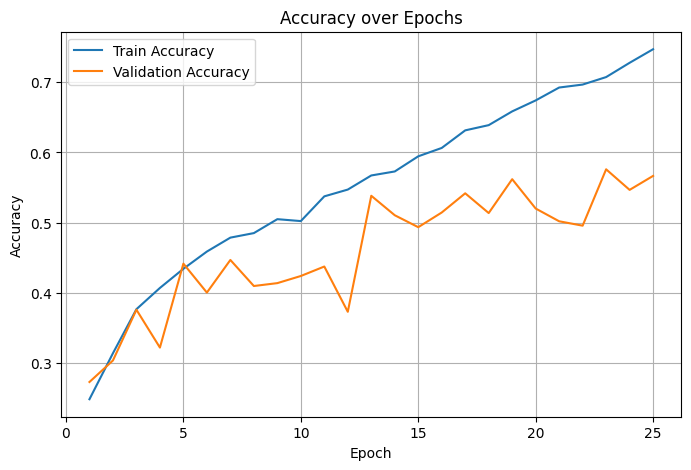

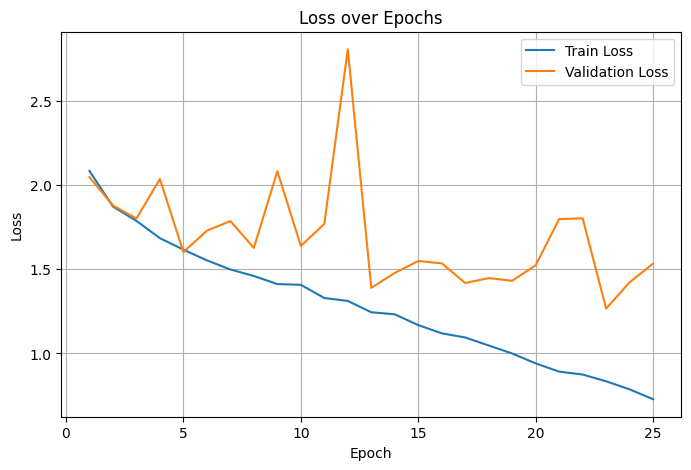

In [36]:
draw_graphs(*train_res_3_2_C)

### 3.3: Эксперименты с функциями активации

Эксперимент:

    Используйте лучшую конфигурацию из Этапа 3.2 (каналы + количество блоков)
    Обучите модели с разными активациями:
        Вариант A: ReLU (baseline)
        Вариант B: LeakyReLU
        Вариант C: ELU
        Вариант D: GELU


In [37]:
print(max(train_res_3_2_A[-2]), max(train_res_3_2_A[-1]))
print(max(train_res_3_2_B[-2]), max(train_res_3_2_B[-1]))
print(max(train_res_3_2_C[-2]), max(train_res_3_2_C[-1]))

0.7683531746031746 0.5810546875
0.7584325396825397 0.5740234375
0.7470238095238095 0.5759765625


In [38]:
from torch import nn

# best_num_blocks = [2, 2, 2, 2]
best_num_blocks = [1, 1, 1, 1]

model_3_3_A = ResNet18(use_layer4=False, channels=best_channels, num_blocks=best_num_blocks, activation_fn=nn.ReLU(inplace=True))
model_3_3_B = ResNet18(use_layer4=False, channels=best_channels, num_blocks=best_num_blocks, activation_fn=nn.LeakyReLU(inplace=True))
model_3_3_C = ResNet18(use_layer4=False, channels=best_channels, num_blocks=best_num_blocks, activation_fn=nn.ELU(inplace=True))
model_3_3_D = ResNet18(use_layer4=False, channels=best_channels, num_blocks=best_num_blocks, activation_fn=nn.GELU())

### 3.3.A

In [39]:
train_res_3_3_A = train(model_3_3_A, train_loader, val_loader)

Epoch [1/25] | Train Loss: 1.9765, Train Acc: 0.3028 | Val Loss: 2.0517, Val Acc: 0.2986
Epoch [2/25] | Train Loss: 1.8258, Train Acc: 0.3601 | Val Loss: 1.7844, Val Acc: 0.3658
Epoch [3/25] | Train Loss: 1.6937, Train Acc: 0.4070 | Val Loss: 2.0333, Val Acc: 0.3598
Epoch [4/25] | Train Loss: 1.5863, Train Acc: 0.4539 | Val Loss: 1.5894, Val Acc: 0.4260
Epoch [5/25] | Train Loss: 1.5267, Train Acc: 0.4725 | Val Loss: 1.8242, Val Acc: 0.3957
Epoch [6/25] | Train Loss: 1.4609, Train Acc: 0.4938 | Val Loss: 1.7055, Val Acc: 0.4387
Epoch [7/25] | Train Loss: 1.4245, Train Acc: 0.5149 | Val Loss: 1.8808, Val Acc: 0.4205
Epoch [8/25] | Train Loss: 1.3587, Train Acc: 0.5350 | Val Loss: 1.6520, Val Acc: 0.4631
Epoch [9/25] | Train Loss: 1.2921, Train Acc: 0.5613 | Val Loss: 1.7634, Val Acc: 0.4594
Epoch [10/25] | Train Loss: 1.2471, Train Acc: 0.5744 | Val Loss: 2.1930, Val Acc: 0.4004
Epoch [11/25] | Train Loss: 1.2036, Train Acc: 0.5975 | Val Loss: 1.7938, Val Acc: 0.4395
Epoch [12/25] | Tra

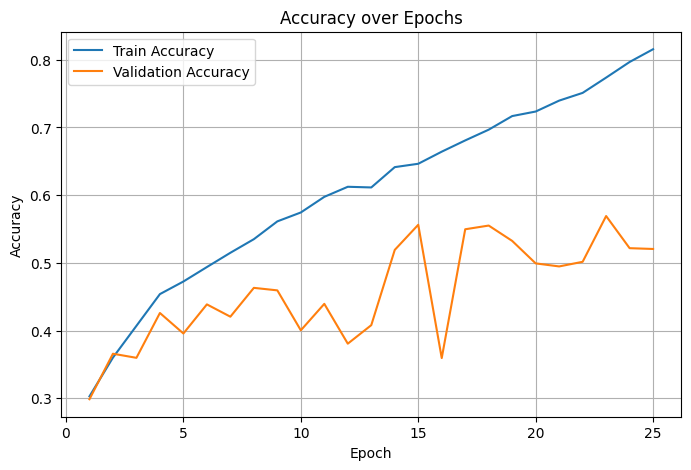

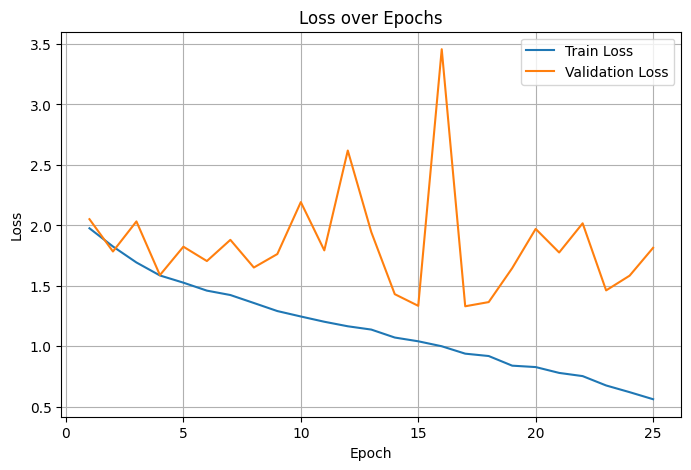

In [40]:
draw_graphs(*train_res_3_3_A)

### 3.3.B

In [41]:
train_res_3_3_B = train(model_3_3_B, train_loader, val_loader)

Epoch [1/25] | Train Loss: 1.9919, Train Acc: 0.2927 | Val Loss: 2.0832, Val Acc: 0.2680
Epoch [2/25] | Train Loss: 1.8328, Train Acc: 0.3589 | Val Loss: 1.8636, Val Acc: 0.3477
Epoch [3/25] | Train Loss: 1.7289, Train Acc: 0.3996 | Val Loss: 1.8032, Val Acc: 0.3658
Epoch [4/25] | Train Loss: 1.6316, Train Acc: 0.4345 | Val Loss: 1.8398, Val Acc: 0.3719
Epoch [5/25] | Train Loss: 1.5464, Train Acc: 0.4675 | Val Loss: 2.1887, Val Acc: 0.3805
Epoch [6/25] | Train Loss: 1.5027, Train Acc: 0.4757 | Val Loss: 1.5157, Val Acc: 0.4830
Epoch [7/25] | Train Loss: 1.4367, Train Acc: 0.5025 | Val Loss: 1.4954, Val Acc: 0.5055
Epoch [8/25] | Train Loss: 1.3778, Train Acc: 0.5250 | Val Loss: 1.7148, Val Acc: 0.4570
Epoch [9/25] | Train Loss: 1.3450, Train Acc: 0.5437 | Val Loss: 1.6258, Val Acc: 0.4559
Epoch [10/25] | Train Loss: 1.2980, Train Acc: 0.5565 | Val Loss: 1.3640, Val Acc: 0.5414
Epoch [11/25] | Train Loss: 1.2464, Train Acc: 0.5759 | Val Loss: 1.5244, Val Acc: 0.4918
Epoch [12/25] | Tra

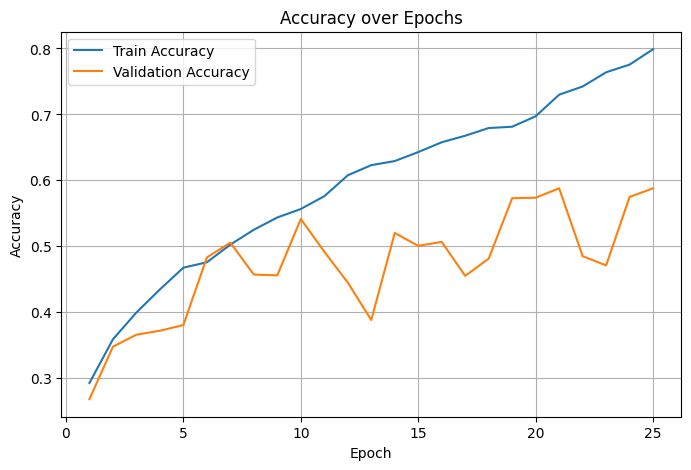

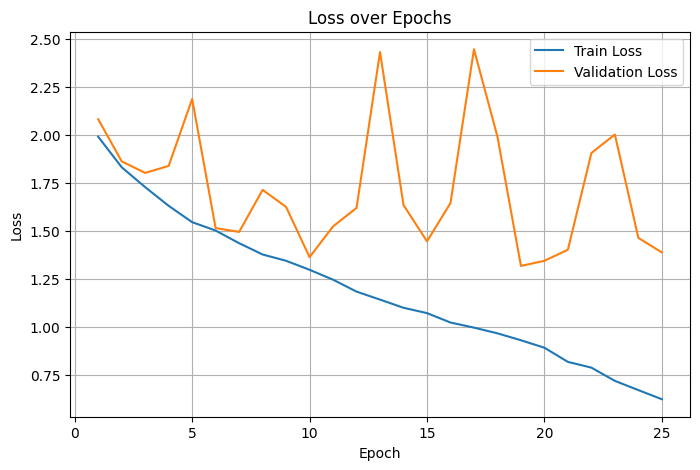

In [42]:
draw_graphs(*train_res_3_3_B)

### 3.3.C

In [43]:
train_res_3_3_C = train(model_3_3_C, train_loader, val_loader)

Epoch [1/25] | Train Loss: 1.9710, Train Acc: 0.2954 | Val Loss: 1.9611, Val Acc: 0.3211
Epoch [2/25] | Train Loss: 1.7887, Train Acc: 0.3752 | Val Loss: 2.0509, Val Acc: 0.3227
Epoch [3/25] | Train Loss: 1.6552, Train Acc: 0.4152 | Val Loss: 1.7647, Val Acc: 0.3682
Epoch [4/25] | Train Loss: 1.5877, Train Acc: 0.4425 | Val Loss: 2.2221, Val Acc: 0.3463
Epoch [5/25] | Train Loss: 1.5022, Train Acc: 0.4717 | Val Loss: 2.1522, Val Acc: 0.3576
Epoch [6/25] | Train Loss: 1.4441, Train Acc: 0.5027 | Val Loss: 1.5231, Val Acc: 0.4771
Epoch [7/25] | Train Loss: 1.3861, Train Acc: 0.5213 | Val Loss: 1.8041, Val Acc: 0.4393
Epoch [8/25] | Train Loss: 1.3119, Train Acc: 0.5503 | Val Loss: 5.2247, Val Acc: 0.2393
Epoch [9/25] | Train Loss: 1.2709, Train Acc: 0.5699 | Val Loss: 1.9160, Val Acc: 0.4246
Epoch [10/25] | Train Loss: 1.2329, Train Acc: 0.5747 | Val Loss: 3.3610, Val Acc: 0.3727
Epoch [11/25] | Train Loss: 1.1786, Train Acc: 0.6076 | Val Loss: 1.7955, Val Acc: 0.4473
Epoch [12/25] | Tra

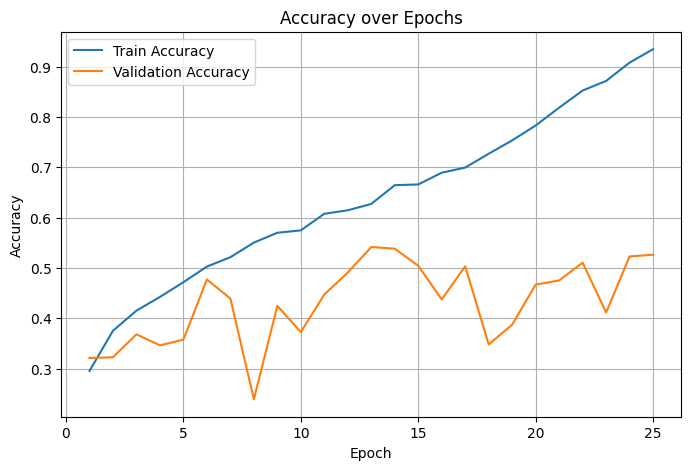

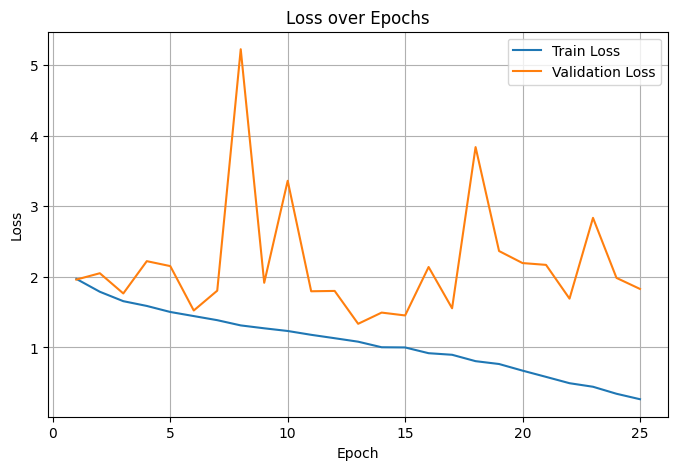

In [44]:
draw_graphs(*train_res_3_3_C)

### 3.3.D

In [45]:
train_res_3_3_D = train(model_3_3_D, train_loader, val_loader)

Epoch [1/25] | Train Loss: 2.0192, Train Acc: 0.2624 | Val Loss: 1.8792, Val Acc: 0.3439
Epoch [2/25] | Train Loss: 1.8351, Train Acc: 0.3490 | Val Loss: 1.9962, Val Acc: 0.3123
Epoch [3/25] | Train Loss: 1.7274, Train Acc: 0.4030 | Val Loss: 1.8114, Val Acc: 0.3523
Epoch [4/25] | Train Loss: 1.6426, Train Acc: 0.4286 | Val Loss: 2.0359, Val Acc: 0.3158
Epoch [5/25] | Train Loss: 1.5471, Train Acc: 0.4556 | Val Loss: 2.0772, Val Acc: 0.3814
Epoch [6/25] | Train Loss: 1.4836, Train Acc: 0.4958 | Val Loss: 1.6466, Val Acc: 0.4912
Epoch [7/25] | Train Loss: 1.4464, Train Acc: 0.4990 | Val Loss: 1.7347, Val Acc: 0.4146
Epoch [8/25] | Train Loss: 1.3635, Train Acc: 0.5248 | Val Loss: 1.8379, Val Acc: 0.3615
Epoch [9/25] | Train Loss: 1.3263, Train Acc: 0.5449 | Val Loss: 1.4177, Val Acc: 0.5369
Epoch [10/25] | Train Loss: 1.2853, Train Acc: 0.5642 | Val Loss: 1.6997, Val Acc: 0.4479
Epoch [11/25] | Train Loss: 1.2413, Train Acc: 0.5794 | Val Loss: 1.5065, Val Acc: 0.4961
Epoch [12/25] | Tra

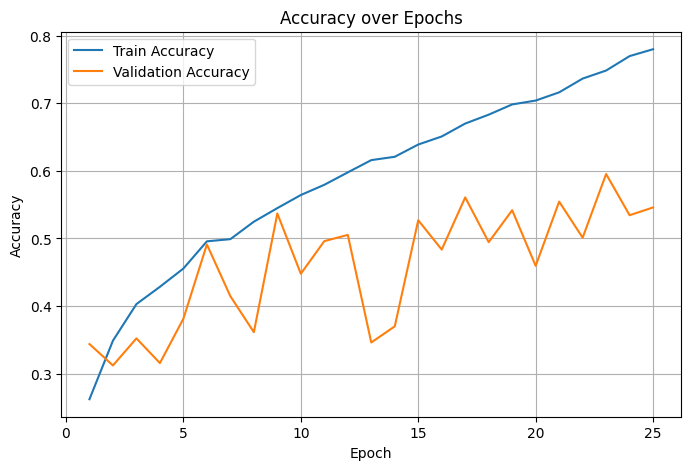

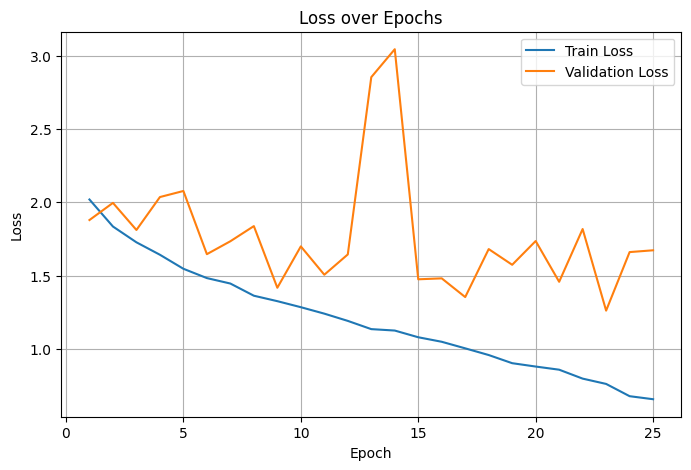

In [46]:
draw_graphs(*train_res_3_3_D)

## Часть 4: Финальная модель и тестирование

In [47]:
print(max(train_res_3_3_A[-2]), max(train_res_3_3_A[-1]))
print(max(train_res_3_3_B[-2]), max(train_res_3_3_B[-1]))
print(max(train_res_3_3_C[-2]), max(train_res_3_3_C[-1]))
print(max(train_res_3_3_D[-2]), max(train_res_3_3_D[-1]))

0.8154761904761905 0.569140625
0.798859126984127 0.587890625
0.9345238095238095 0.5416015625
0.7797619047619048 0.5953125


In [72]:
# best_activation_fn = nn.ReLU(inplace=True)
best_activation_fn =nn.GELU()
model_final = ResNet18(use_layer4=False, channels=best_channels, num_blocks=best_num_blocks, activation_fn=best_activation_fn)

In [75]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = TinyImageNetDataset(
    root_dir="../hw_2/tiny-imagenet-200",
    transform=train_transform,
    selected_classes=classes
)

val_dataset = TinyImageNetDataset(
    root_dir="../hw_2/tiny-imagenet-200",
    transform=val_transform,
    selected_classes=classes
)

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(train_dataset)))
labels = [train_dataset[i][1] for i in indices]

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)


train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [76]:
train_res_final = train(model_final, train_loader, val_loader, num_epochs = 40)

Epoch [1/40] | Train Loss: 1.0720, Train Acc: 0.6391 | Val Loss: 1.3918, Val Acc: 0.5602
Epoch [2/40] | Train Loss: 1.0111, Train Acc: 0.6659 | Val Loss: 1.3934, Val Acc: 0.5793
Epoch [3/40] | Train Loss: 0.9888, Train Acc: 0.6657 | Val Loss: 1.2712, Val Acc: 0.5826
Epoch [4/40] | Train Loss: 0.9718, Train Acc: 0.6768 | Val Loss: 1.8165, Val Acc: 0.5078
Epoch [5/40] | Train Loss: 0.9514, Train Acc: 0.6749 | Val Loss: 1.2403, Val Acc: 0.5973
Epoch [6/40] | Train Loss: 0.9175, Train Acc: 0.6885 | Val Loss: 1.4581, Val Acc: 0.5529
Epoch [7/40] | Train Loss: 0.9120, Train Acc: 0.6944 | Val Loss: 1.5122, Val Acc: 0.5342
Epoch [8/40] | Train Loss: 0.8979, Train Acc: 0.7001 | Val Loss: 1.4373, Val Acc: 0.5430
Epoch [9/40] | Train Loss: 0.8804, Train Acc: 0.7016 | Val Loss: 1.3014, Val Acc: 0.5982
Epoch [10/40] | Train Loss: 0.8533, Train Acc: 0.7101 | Val Loss: 1.2233, Val Acc: 0.6070
Epoch [11/40] | Train Loss: 0.8098, Train Acc: 0.7282 | Val Loss: 1.7276, Val Acc: 0.5324
Epoch [12/40] | Tra

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np



y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = model_final(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_dataset.class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

   n01443537       0.94      0.91      0.92       100
   n01629819       0.92      0.83      0.87       100
   n01641577       0.51      0.76      0.61       100
   n01644900       0.34      0.48      0.40       100
   n01698640       0.64      0.58      0.61       100
   n01742172       0.55      0.62      0.58       100
   n01768244       0.81      0.64      0.72       100
   n01770393       0.50      0.20      0.29       100
   n01774384       0.69      0.68      0.69       100
   n01774750       0.53      0.56      0.55       100

    accuracy                           0.63      1000
   macro avg       0.64      0.63      0.62      1000
weighted avg       0.64      0.63      0.62      1000

Confusion Matrix:
[[91  0  1  2  0  2  1  0  2  1]
 [ 1 83  5  4  3  0  0  0  3  1]
 [ 0  1 76 13  5  2  1  0  1  1]
 [ 2  2 28 48  4  4  4  2  0  6]
 [ 0  0 18  9 58  9  0  1  3  2]
 [ 0  0  5 17  2 62  0  5  2  7]
 [

In [78]:
torch.save(model_final.state_dict(), "resnet18_weights.pth")

Смотрим на 10 случайных изображений:

In [79]:
def load_label_mapping(words_file_path):

    label_map = {}

    with open(words_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            key, value = line.split('\t', 1)
            
            class_name = value.split(',')[0].strip()
            
            label_map[key] = class_name

    return label_map
words_path = "../hw_2/tiny-imagenet-200/words.txt"
label_mapping = load_label_mapping(words_path)

### Визуальный анализ

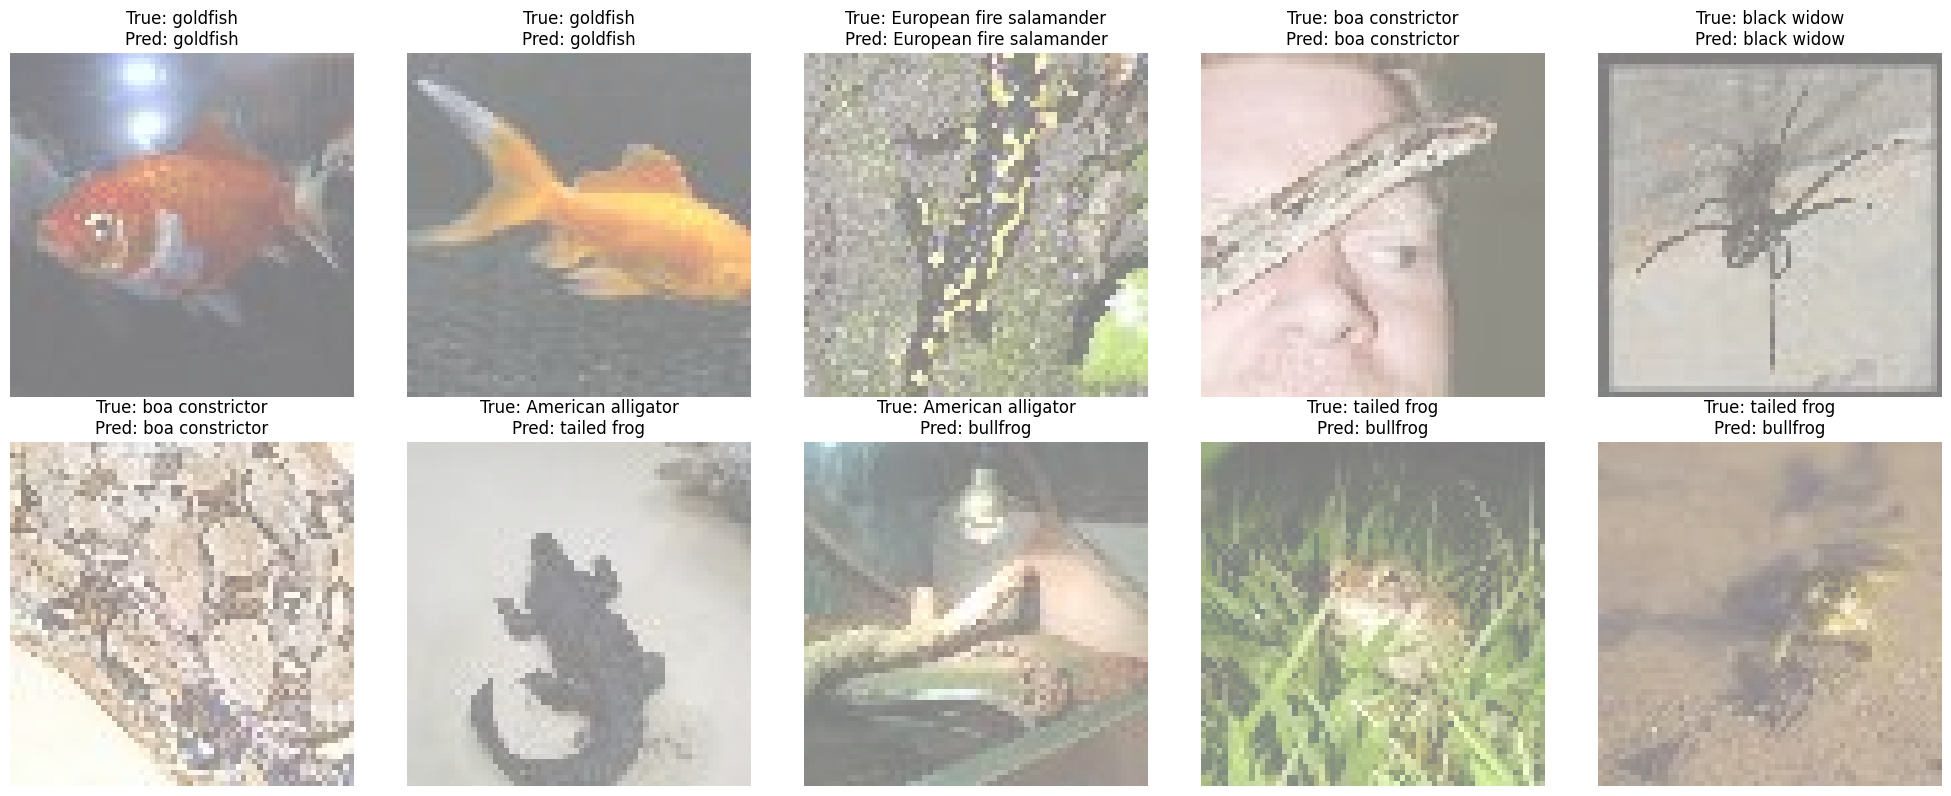

In [80]:
import matplotlib.pyplot as plt
import random
import torch

model_final.eval()

images, labels = next(iter(val_loader))

num_images = min(10, images.size(0))
indices = random.sample(range(images.size(0)), num_images)

images = images.to("cuda")
labels = labels.to("cuda")

with torch.no_grad():
    outputs = model_final(images)
    preds = torch.argmax(outputs, dim=1)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img = images[idx].cpu()
    label = labels[idx].item()
    pred = preds[idx].item()

    img = img * 0.5 + 0.5
    img = img.permute(1, 2, 0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(
        f"True: {label_mapping[val_loader.dataset.dataset.class_names[label]]}\n"
        f"Pred: {label_mapping[val_loader.dataset.dataset.class_names[pred]]}"
    )
    axes[i].axis("off")

plt.tight_layout()
plt.show()



### Сравнительная таблица всех экспериментов

In [89]:
def fmt_params(model):
    return f"{count_parameters(model) / 1e6:.1f}M"

def fmt_acc(x):
    return f"{x * 100:.1f}%"

print("| Этап | Конфигурация | Параметры | Val Accuracy | Train Accuracy |")
print("|------|--------------|-----------|--------------|----------------|")

print(f"| **Baseline** | базовая модель | {fmt_params(base_model)} | "
      f"{fmt_acc(max(base_val_accs))} | {fmt_acc(max(base_train_accs))} |")

print(f"| **3.1-A** | 32→64→128→256 | {fmt_params(model_3_1_A)} | "
      f"{fmt_acc(max(train_res_3_1_A[-1]))} | {fmt_acc(max(train_res_3_1_A[-2]))} |")

print(f"| **3.1-B** | 64→128→256 | {fmt_params(model_3_1_B)} | "
      f"{fmt_acc(max(train_res_3_1_B[-1]))} | {fmt_acc(max(train_res_3_1_B[-2]))} |")

print(f"| **3.2-A** | [1,1,1,1] блоков | {fmt_params(model_3_2_A)} | "
      f"{fmt_acc(max(train_res_3_2_A[-1]))} | {fmt_acc(max(train_res_3_2_A[-2]))} |")

print(f"| **3.2-B** | [2,2,2,2] блоков | {fmt_params(model_3_2_B)} | "
      f"{fmt_acc(max(train_res_3_2_B[-1]))} | {fmt_acc(max(train_res_3_2_B[-2]))} |")

print(f"| **3.2-C** | [3,3,3,3] блоков | {fmt_params(model_3_2_C)} | "
      f"{fmt_acc(max(train_res_3_2_C[-1]))} | {fmt_acc(max(train_res_3_2_C[-2]))} |")

print(f"| **3.3-A** | ReLU | {fmt_params(model_3_3_A)} | "
      f"{fmt_acc(max(train_res_3_3_A[-1]))} | {fmt_acc(max(train_res_3_3_A[-2]))} |")

print(f"| **3.3-B** | LeakyReLU | {fmt_params(model_3_3_B)} | "
      f"{fmt_acc(max(train_res_3_3_B[-1]))} | {fmt_acc(max(train_res_3_3_B[-2]))} |")

print(f"| **3.3-C** | ELU | {fmt_params(model_3_3_C)} | "
      f"{fmt_acc(max(train_res_3_3_C[-1]))} | {fmt_acc(max(train_res_3_3_C[-2]))} |")

print(f"| **3.3-D** | GELU | {fmt_params(model_3_3_D)} | "
      f"{fmt_acc(max(train_res_3_3_D[-1]))} | {fmt_acc(max(train_res_3_3_D[-2]))} |")
print(f"| **Final** | Лучшая конфигурация | {fmt_params(model_final)} | "
      f"{fmt_acc(max(train_res_final[-1]))} | {fmt_acc(max(train_res_final[-2]))} |")


| Этап | Конфигурация | Параметры | Val Accuracy | Train Accuracy |
|------|--------------|-----------|--------------|----------------|
| **Baseline** | базовая модель | 4.0M | 59.6% | 97.9% |
| **3.1-A** | 32→64→128→256 | 2.8M | 57.6% | 98.8% |
| **3.1-B** | 64→128→256 | 2.8M | 61.6% | 95.5% |
| **3.2-A** | [1,1,1,1] блоков | 1.2M | 58.1% | 76.8% |
| **3.2-B** | [2,2,2,2] блоков | 2.8M | 57.4% | 75.8% |
| **3.2-C** | [3,3,3,3] блоков | 4.3M | 57.6% | 74.7% |
| **3.3-A** | ReLU | 1.2M | 56.9% | 81.5% |
| **3.3-B** | LeakyReLU | 1.2M | 58.8% | 79.9% |
| **3.3-C** | ELU | 1.2M | 54.2% | 93.5% |
| **3.3-D** | GELU | 1.2M | 59.5% | 78.0% |
| **Final** | Лучшая конфигурация | 1.2M | 63.6% | 86.2% |


| Этап | Конфигурация | Параметры | Val Accuracy | Train Accuracy |
|------|--------------|-----------|--------------|----------------|
| **Baseline** | базовая модель | 4.0M | 59.6% | 97.9% |
| **3.1-A** | 32→64→128→256 | 2.8M | 57.6% | 98.8% |
| **3.1-B** | 64→128→256 | 2.8M | 61.6% | 95.5% |
| **3.2-A** | [1,1,1,1] блоков | 1.2M | 58.1% | 76.8% |
| **3.2-B** | [2,2,2,2] блоков | 2.8M | 57.4% | 75.8% |
| **3.2-C** | [3,3,3,3] блоков | 4.3M | 57.6% | 74.7% |
| **3.3-A** | ReLU | 1.2M | 56.9% | 81.5% |
| **3.3-B** | LeakyReLU | 1.2M | 58.8% | 79.9% |
| **3.3-C** | ELU | 1.2M | 54.2% | 93.5% |
| **3.3-D** | GELU | 1.2M | 59.5% | 78.0% |
| **Final** | Лучшая конфигурация | 1.2M | 63.6% | 86.2% |

Наилучший результат показала финальная модель с конфигурацией 64→128→256, [1,1,1,1] блоками, GELU и аугментациями в трейне (случайное отражение и случайный поворот на +-10). Во всех эксперементах лучшие результаты показывала модель с меньшим числом параметров. Также в первых экспериментах наблюдалось большое расхождение точности на трейн и валидации, что свидетельствует о переобучении модели.